In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from imblearn.under_sampling import RandomUnderSampler

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [8]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Prepare Data

In [91]:
df = pd.read_csv("gaze_labels.csv", index_col = "Participant_ID")

In [92]:
df.head()

,PHQ_Score,PHQ_Binary
Participant_ID,,
300,2,0
301,3,0
302,4,0
303,0,0
304,6,0


In [93]:
# X = np.load("gaze_features.npy")
X = np.load("avg_gaze.npy")
y = np.array(df['PHQ_Binary'])

In [94]:
X.shape

(181, 14)

In [95]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [74]:
def balance_data(X,y):
    new_y = []
    new_X = []
    dep_count = sum(y)
    count = 0
    for i in range(X.shape[0]):
        if y[i]==0:
            if count<dep_count:
                new_y.append(y[i])
                new_X.append(X[i])
                count+=1
        else:
            new_y.append(y[i])
            new_X.append(X[i])
    return np.array(new_X), np.array(new_y)

In [66]:
X_train, y_train =balance_data(X_train,y_train)

In [67]:
X_train.shape

(102, 12447, 14)

In [96]:
# the ratio of minority class to majority class will be 1 after resampling
us = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)

X_train, y_train = us.fit_sample(X_train, y_train)

# Evaluation Metrics

In [76]:
def evaluate_on_training_set(y_test, y_pred):
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

# Neural Network Model

In [18]:
# n_input = X_train.shape[1]
# n_features = X_train.shape[2]
# input_shape = (n_input, n_features)

In [29]:
model = Sequential()
# model.add(LSTM(100, input_shape=input_shape, return_sequences=True))
# model.add(LSTM(50, input_shape=input_shape))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
checkpoint_filepath = 'model.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

In [31]:
model.fit(X_train, y_train, batch_size=16, epochs=30, validation_split=0.1, callbacks=[es, checkpoint])

Train on 91 samples, validate on 11 samples
Epoch 1/30
91/91 [==============================] - 0s 3ms/step - loss: 1.5923 - accuracy: 0.4396 - val_loss: 0.0674 - val_accuracy: 1.0000
Epoch 2/30
91/91 [==============================] - 0s 427us/step - loss: 1.5284 - accuracy: 0.4396 - val_loss: 0.0771 - val_accuracy: 1.0000
Epoch 3/30
91/91 [==============================] - 0s 471us/step - loss: 1.4660 - accuracy: 0.4396 - val_loss: 0.0885 - val_accuracy: 1.0000
Epoch 4/30
91/91 [==============================] - 0s 460us/step - loss: 1.3988 - accuracy: 0.4396 - val_loss: 0.1008 - val_accuracy: 1.0000
Epoch 5/30
91/91 [==============================] - 0s 449us/step - loss: 1.3358 - accuracy: 0.4396 - val_loss: 0.1146 - val_accuracy: 1.0000
Epoch 6/30
91/91 [==============================] - 0s 581us/step - loss: 1.2747 - accuracy: 0.4396 - val_loss: 0.1300 - val_accuracy: 1.0000


In [32]:
model = load_model(checkpoint_filepath)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0] 

AUC is:  0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.21      1.00      0.35         4

    accuracy                           0.21        19
   macro avg       0.11      0.50      0.17        19
weighted avg       0.04      0.21      0.07        19

Confusion Matrix: 
 [[ 0 15]
 [ 0  4]]


C:\Users\65842\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


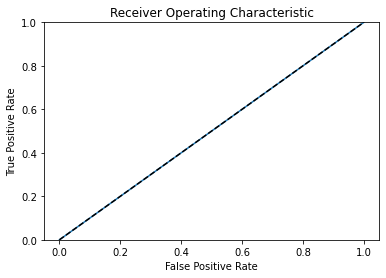

In [33]:
predictions = model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()

print(y_pred)
print(y_test, '\n')

evaluate_on_training_set(y_test, y_pred)

# k cross

In [97]:
def k_cross(model, X=X_train, y=y_train, k=10, n=1, random_state=RANDOM_STATE):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=RANDOM_STATE)
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

# Evaluation

In [98]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(y_pred)
    print(y_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Logistic Regression

In [99]:
def find_best_logreg_model(power):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for i in range(power + 1):
        model = LogisticRegression(n_jobs=3, C=10**i)
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"power: {i}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"power: {i}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_logreg_f1_model, best_logreg_recall_model = find_best_logreg_model(6)

power: 0: f1 = 0.4040909090909091 > best f1 = -1
power: 0: recall = 0.5766666666666667 > best recall = -1
power: 1: f1 = 0.4246031746031746 > best f1 = 0.4040909090909091


[1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.458041958041958
              precision    recall  f1-score   support

           0       0.67      0.46      0.55        26
           1       0.26      0.45      0.33        11

    accuracy                           0.46        37
   macro avg       0.46      0.46      0.44        37
weighted avg       0.55      0.46      0.48        37

Confusion Matrix: 
 [[12 14]
 [ 6  5]]


LogisticRegression(C=10, n_jobs=3)

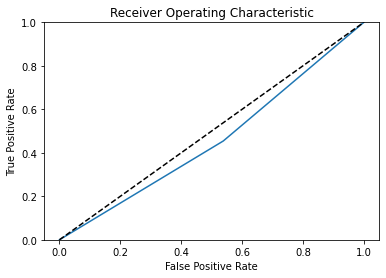

In [100]:
# Based on f1
evaluate_model(best_logreg_f1_model)

# Decision Tree

In [101]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                print(f"depth: {depth}, leaf: {leaf}: f1 = {f1} > best f1 = {best_f1}")
                best_f1 = f1
                best_f1_model = model
                
            if recall > best_recall:
                print(f"depth: {depth}, leaf: {leaf}: recall = {recall} > best recall = {best_recall}")
                best_recall = recall
                best_recall_model = model
    
    return best_f1_model, best_recall_model

best_tree_f1_model, best_tree_recall_model = find_best_tree_model(20, 30)

depth: 1, leaf: 1: f1 = 0.3602020202020202 > best f1 = -1
depth: 1, leaf: 1: recall = 0.48 > best recall = -1
depth: 1, leaf: 7: f1 = 0.46960372960372954 > best f1 = 0.3602020202020202
depth: 1, leaf: 7: recall = 0.58 > best recall = 0.48
depth: 1, leaf: 8: f1 = 0.5465268065268065 > best f1 = 0.46960372960372954
depth: 1, leaf: 8: recall = 0.6633333333333333 > best recall = 0.58


[1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.5174825174825175
              precision    recall  f1-score   support

           0       0.73      0.31      0.43        26
           1       0.31      0.73      0.43        11

    accuracy                           0.43        37
   macro avg       0.52      0.52      0.43        37
weighted avg       0.60      0.43      0.43        37

Confusion Matrix: 
 [[ 8 18]
 [ 3  8]]


DecisionTreeClassifier(max_depth=1, min_samples_leaf=8, random_state=42)

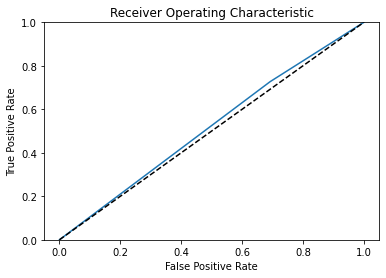

In [102]:
# Based on f1
evaluate_model(best_tree_f1_model)

[1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.5174825174825175
              precision    recall  f1-score   support

           0       0.73      0.31      0.43        26
           1       0.31      0.73      0.43        11

    accuracy                           0.43        37
   macro avg       0.52      0.52      0.43        37
weighted avg       0.60      0.43      0.43        37

Confusion Matrix: 
 [[ 8 18]
 [ 3  8]]


DecisionTreeClassifier(max_depth=1, min_samples_leaf=8, random_state=42)

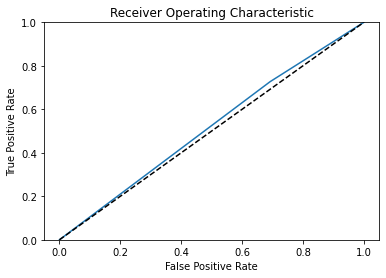

In [103]:
# Based on recall
evaluate_model(best_tree_recall_model)

# RF

In [104]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"estimator: {estimator}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"estimator: {estimator}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_forest_f1_model, best_forest_recall_model = find_best_forest_model(30)

estimator: 1: f1 = 0.4443290043290043 > best f1 = -1
estimator: 1: recall = 0.47166666666666657 > best recall = -1
estimator: 3: recall = 0.4841666666666666 > best recall = 0.47166666666666657
estimator: 5: f1 = 0.5186616161616161 > best f1 = 0.4443290043290043
estimator: 5: recall = 0.6125 > best recall = 0.4841666666666666


[0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.472027972027972
              precision    recall  f1-score   support

           0       0.67      0.31      0.42        26
           1       0.28      0.64      0.39        11

    accuracy                           0.41        37
   macro avg       0.47      0.47      0.40        37
weighted avg       0.55      0.41      0.41        37

Confusion Matrix: 
 [[ 8 18]
 [ 4  7]]


RandomForestClassifier(n_estimators=5, random_state=42)

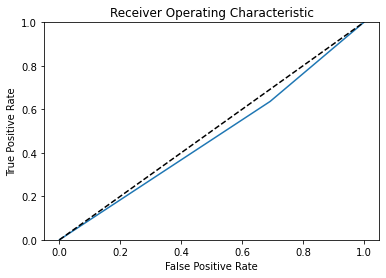

In [105]:
# Based on f1
evaluate_model(best_forest_f1_model)

[0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.472027972027972
              precision    recall  f1-score   support

           0       0.67      0.31      0.42        26
           1       0.28      0.64      0.39        11

    accuracy                           0.41        37
   macro avg       0.47      0.47      0.40        37
weighted avg       0.55      0.41      0.41        37

Confusion Matrix: 
 [[ 8 18]
 [ 4  7]]


RandomForestClassifier(n_estimators=5, random_state=42)

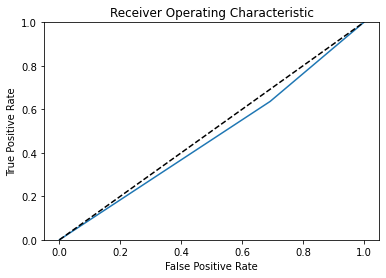

In [106]:
# Based on recall
evaluate_model(best_forest_recall_model)

# SVM with Grid Search

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.3s finished


[1 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.534965034965035
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        26
           1       0.33      0.45      0.38        11

    accuracy                           0.57        37
   macro avg       0.53      0.53      0.53        37
weighted avg       0.61      0.57      0.58        37

Confusion Matrix: 
 [[16 10]
 [ 6  5]]
Best SVM parameters: {'C': 10, 'kernel': 'linear'}


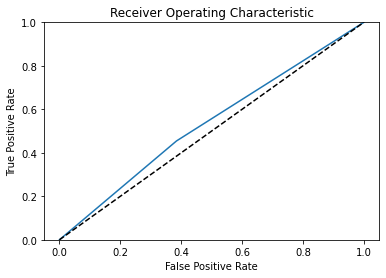

In [107]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

best_svm_model = evaluate_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")